In [62]:
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
def f(x):
    return 4 * x ** 2 + 3 * x - 4
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys);

In [194]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) -1 ) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [79]:
# h = 0.0001
# a = Value(2.0,label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# d1 = a * b + c
# c+=h
# d2 = a * b + c
# print("d1:", d1, "\nd2:", d2, "\nslope:", (d2-d1)/h)

In [119]:
def G():
    h = 0.0001    
    a = Value(2.0,label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a * b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2.0, label='f')
    L = e * f ; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0,label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    d = a * b; d.label = 'd'
    e = d + c ; e.label = 'e'
    f = Value(-2.0, label='f')
    L = e * f ; L.label = 'L'
    L2= L.data
    
    print("L1:", L1, "\nL2:", round(L2,4),"\nslope:", round((L2-L1)/h,4))

G()

L1: -8.0 
L2: -8.0004 
slope: -4.0


In [201]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735807, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() ; o.label = 'o'

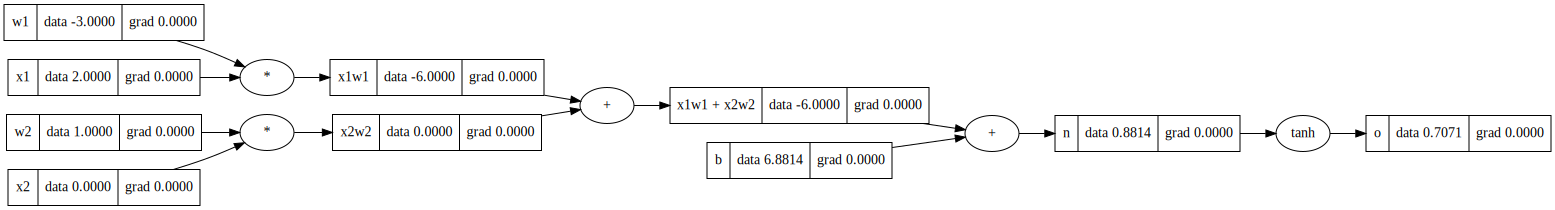

In [202]:
draw_dot(o)

In [203]:
o.backward()

In [185]:
x2w2._backward()

In [152]:
o.grad = 1.0
dodn = n.grad = 1 - o.data ** 2
dndx1w1x2w2 = 1.0
dndb = 1.0
dodx1w1x2w2 = x1w1x2w2.grad = dodn * dndx1w1x2w2
dodb = b.grad = dodn * dndb
dx1w1x2w2dx1w1 = 1.0
dx1w1x2w2dx2w2 = 1.0
dodx2w2 = x2w2.grad = dodx1w1x2w2 * dx1w1x2w2dx2w2
dodx1w1 = x1w1.grad = dodx1w1x2w2 * dx1w1x2w2dx1w1
dx2w2dw2 = x2.data
dx2w2dx2 = w2.data
dx1w1dw1 = x1.data
dx1w1dx1 = w1.data
dodx2 = x2.grad = dodx2w2 * dx2w2dx2
dodw2 = w2.grad = dodx2w2 * dx2w2dw2
dodx1 = x1.grad = dodx1w1 * dx1w1dx1
dodw1 = w1.grad = dodx1w1 * dx1w1dw1


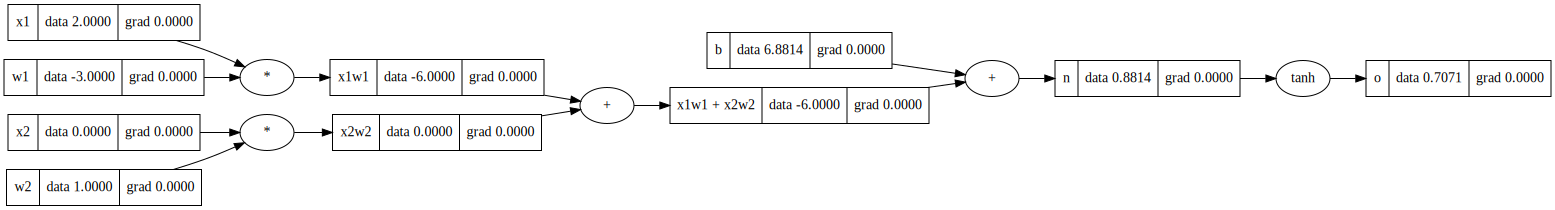

In [156]:
draw_dot(o)